# Section 1

Analyses for Section 1 of the Manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"
df = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')
df.head()

task  N_pos  N_neg   acc  recall  precision  \
0   HIGH_VS_95LOW__3VRL__auto__1__42     10     10  0.80     0.7   0.875000   
1  HIGH_VS_LOOSER__3VRL__auto__1__42     10     10  0.60     0.4   0.666667   
2     ONE_VS_NINE__3VRL__auto__1__42     10     10  0.80     0.7   0.875000   
3   HIGH_VS_95LOW__3VRL__auto__2__42     10     10  0.80     0.7   0.875000   
4  HIGH_VS_LOOSER__3VRL__auto__2__42     10     10  0.55     0.4   0.571429   

         f1  
0  0.777778  
1  0.500000  
2  0.777778  
3  0.777778  
4  0.470588

In [3]:
records = []
for i, row in df.iterrows():
    task_str = row["task"]
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df = pd.merge(df, pd.DataFrame(records), on="task")

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df["task_type_clean"] = df["task_type"].map(map_task_type_to_clean)
df["acc_closed"] = df["acc"].astype(float)

print(df.shape)
df.head()

(1077, 14)


task  N_pos  N_neg   acc  recall  precision  \
0   HIGH_VS_95LOW__3VRL__auto__1__42     10     10  0.80     0.7   0.875000   
1  HIGH_VS_LOOSER__3VRL__auto__1__42     10     10  0.60     0.4   0.666667   
2     ONE_VS_NINE__3VRL__auto__1__42     10     10  0.80     0.7   0.875000   
3   HIGH_VS_95LOW__3VRL__auto__2__42     10     10  0.80     0.7   0.875000   
4  HIGH_VS_LOOSER__3VRL__auto__2__42     10     10  0.55     0.4   0.571429   

         f1 ag_pos ag_neg  seed_id  split_id       task_type task_type_clean  \
0  0.777778   3VRL   auto        1        42   high_vs_95low   vs Non-binder   
1  0.500000   3VRL   auto        1        42  high_vs_looser         vs Weak   
2  0.777778   3VRL   auto        1        42             1v9            vs 9   
3  0.777778   3VRL   auto        2        42   high_vs_95low   vs Non-binder   
4  0.470588   3VRL   auto        2        42  high_vs_looser         vs Weak   

   acc_closed  
0        0.80  
1        0.60  
2        0.80  
3        0.80  
4        0.55

## vs Non-binder, vs Weak, vs 1, vs 9 performances

In [4]:
# Get order of antigens by high_vs_looser performance
ag_order = df.loc[df["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [5]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

/tmp/ipykernel_303215/4142522642.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


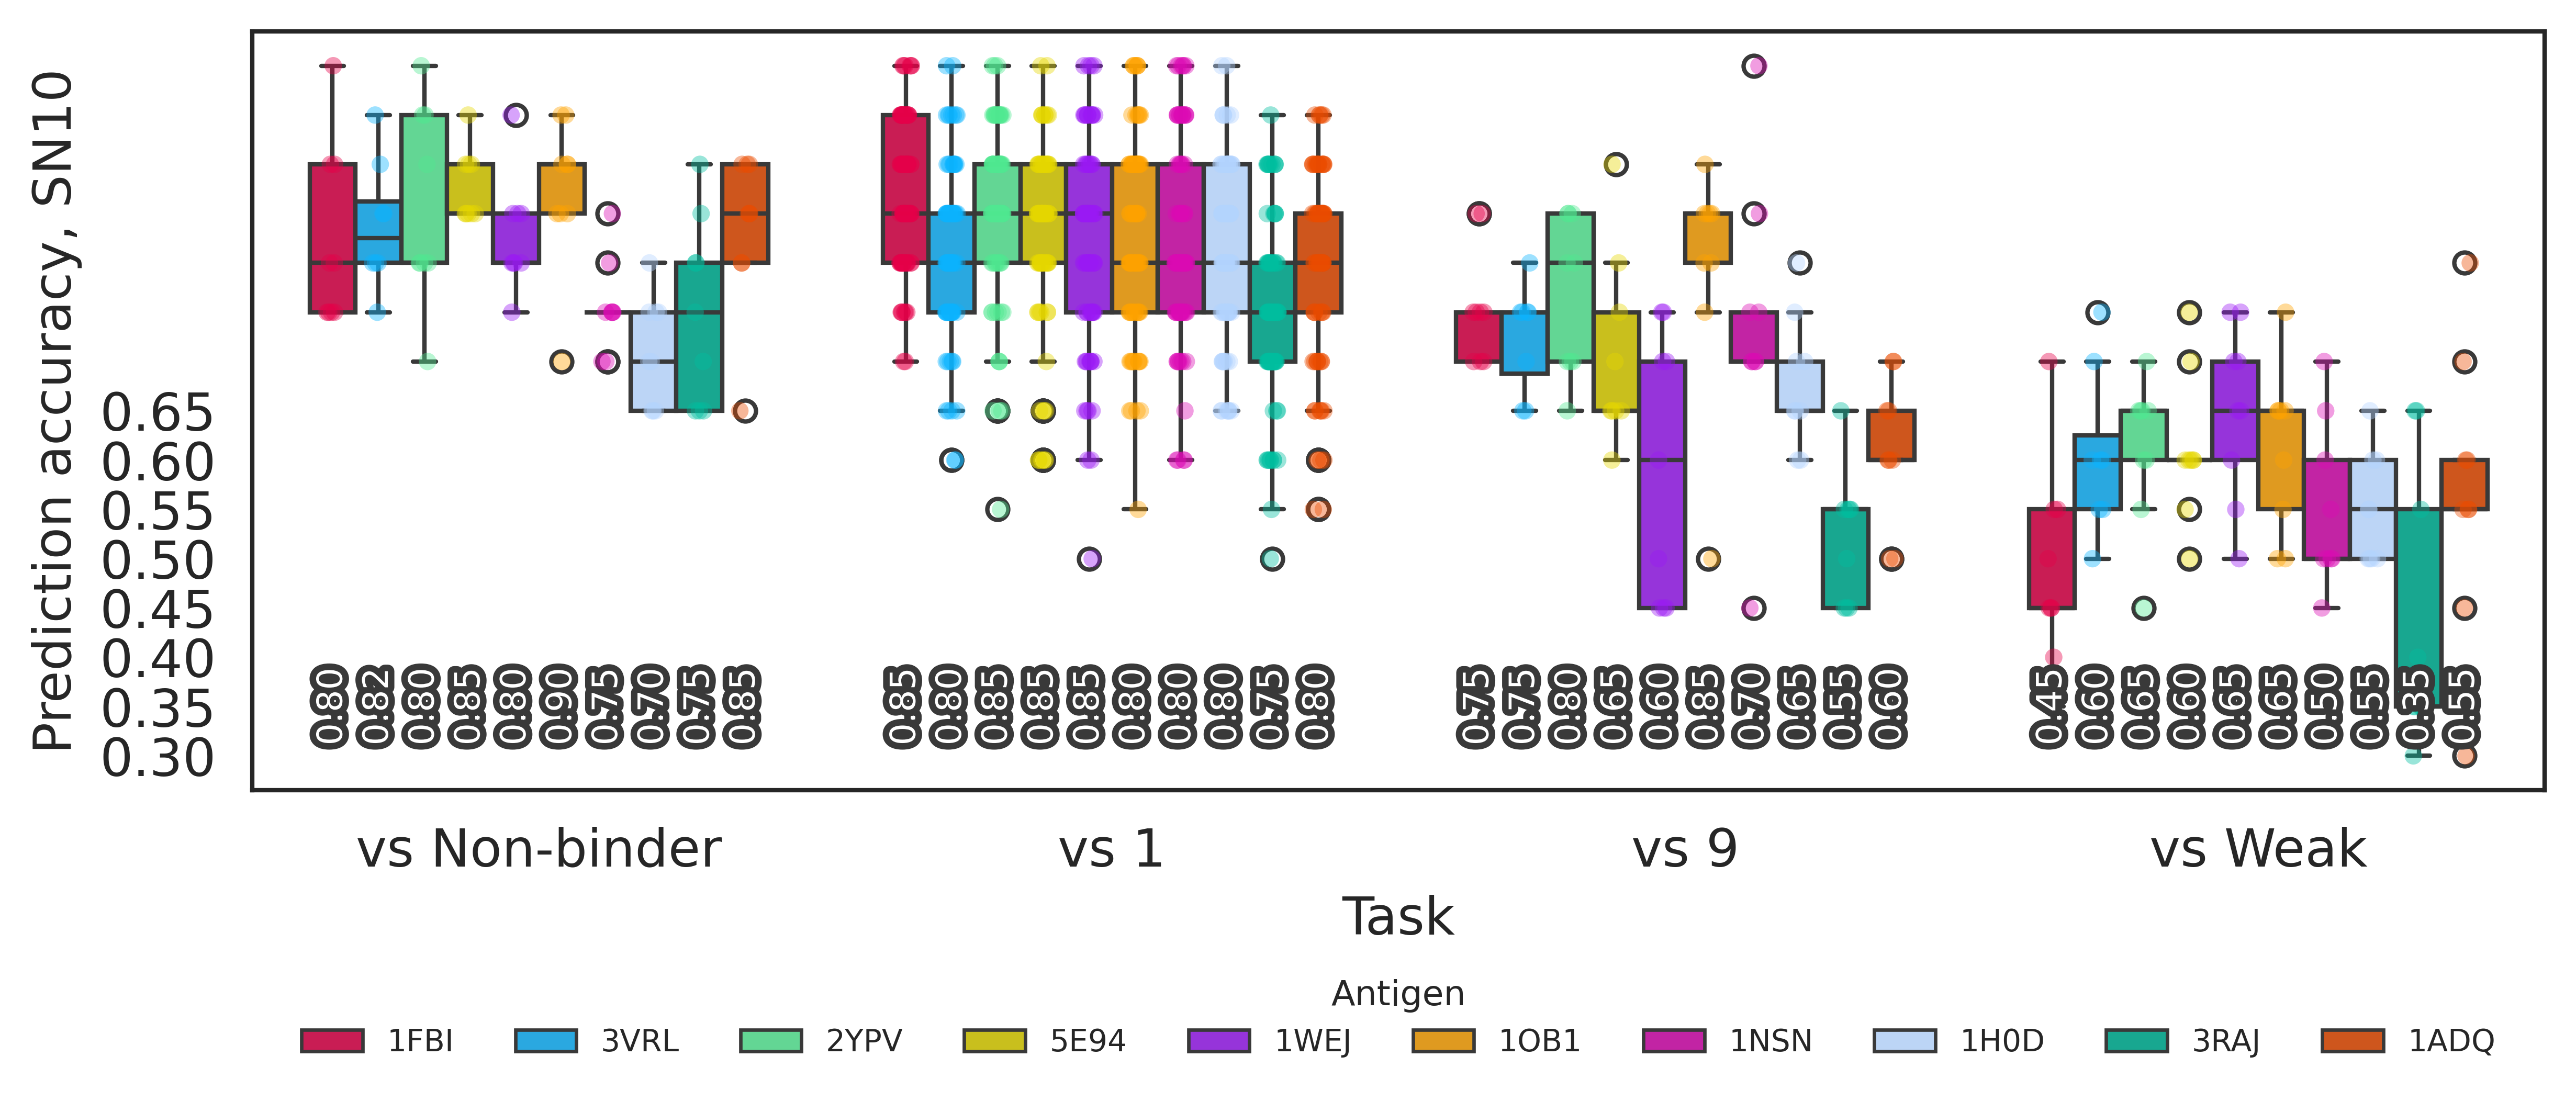

In [6]:
yticks = np.arange(0.3, 0.7, 0.05)
yaxis_title = "Prediction accuracy, SN10"
ag_order = visualisations.PlotParams.order_antigens
task_order = visualisations.PlotParams.order_tasks
task_clean_order = visualisations.PlotParams.order_tasks_clean
cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

# fig.savefig("figures/1C1.svg")
fig.show()

In [7]:
df.groupby("task_type")["acc_closed"].agg(["mean", "std"])

mean       std
task_type                         
1v1             0.817716  0.098338
1v9             0.688202  0.122480
high_vs_95low   0.814045  0.087252
high_vs_looser  0.567978  0.109816

/tmp/ipykernel_303215/552326829.py:9: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(
/tmp/ipykernel_303215/552326829.py:26: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_303215/552326829.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


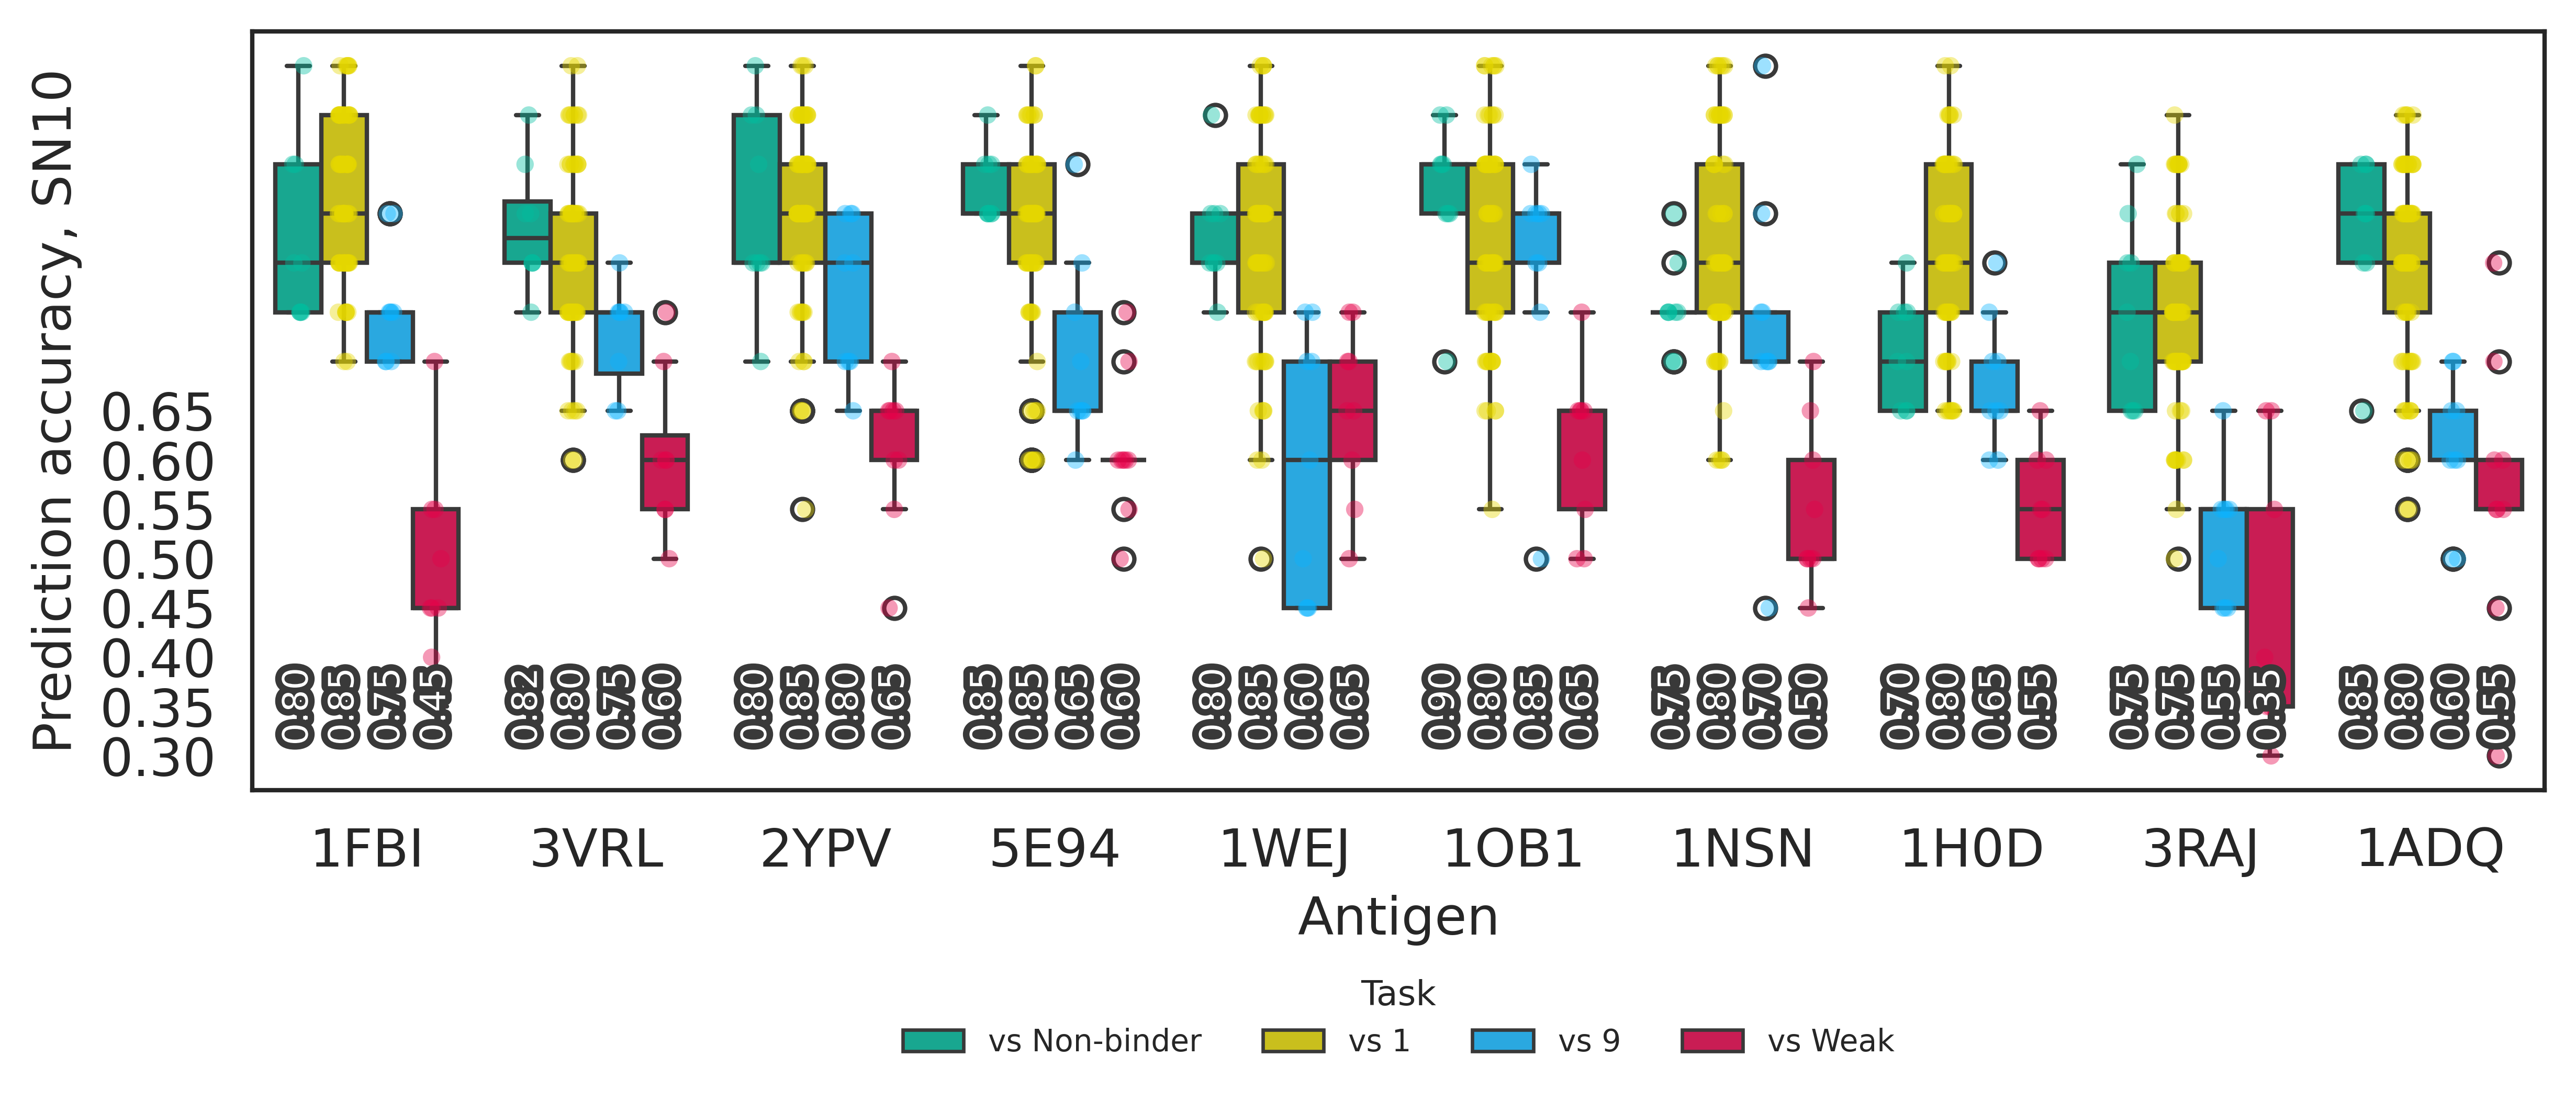

In [8]:
cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)


## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    # palette="Set2",
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    palette=cmap,
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))


visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)
# Add legend under the plot, under x axis label
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

fig.show()

In [9]:
df.groupby("ag_pos")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

mean       std
ag_pos                    
2YPV    0.825926  0.109477
1FBI    0.823148  0.131210
1OB1    0.808333  0.114895
5E94    0.800463  0.113462
3VRL    0.790476  0.101927
1WEJ    0.787500  0.126070
1NSN    0.783796  0.126755
1H0D    0.771759  0.114442
1ADQ    0.764815  0.128117
3RAJ    0.704630  0.139515

## Entropy of slides

In [10]:
from NegativeClassOptimization.utils import jensen_shannon_divergence_slides 

# Compute JSD for each task
loader = datasets.FrozenMiniAbsolutMLLoader(base_p)
jsds = []
for task_str in df["task"]:
    task = datasets.ClassificationTask.init_from_str(task_str)
    
    try:
        loader.load(task, load_model=False)
    except:
        print(f"Failed to load {task_str}")
        raise

    slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list() # type: ignore
    slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list() # type: ignore
    jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
    jsds.append(jsd)
df["jsd"] = jsds

vs 1
vs 1: r=0.34, p=0.00
vs 9
vs 9: r=0.22, p=0.04
vs Non-binder
vs Non-binder: r=0.02, p=0.84
vs Weak
vs Weak: r=-0.23, p=0.03


/tmp/ipykernel_303215/785033084.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


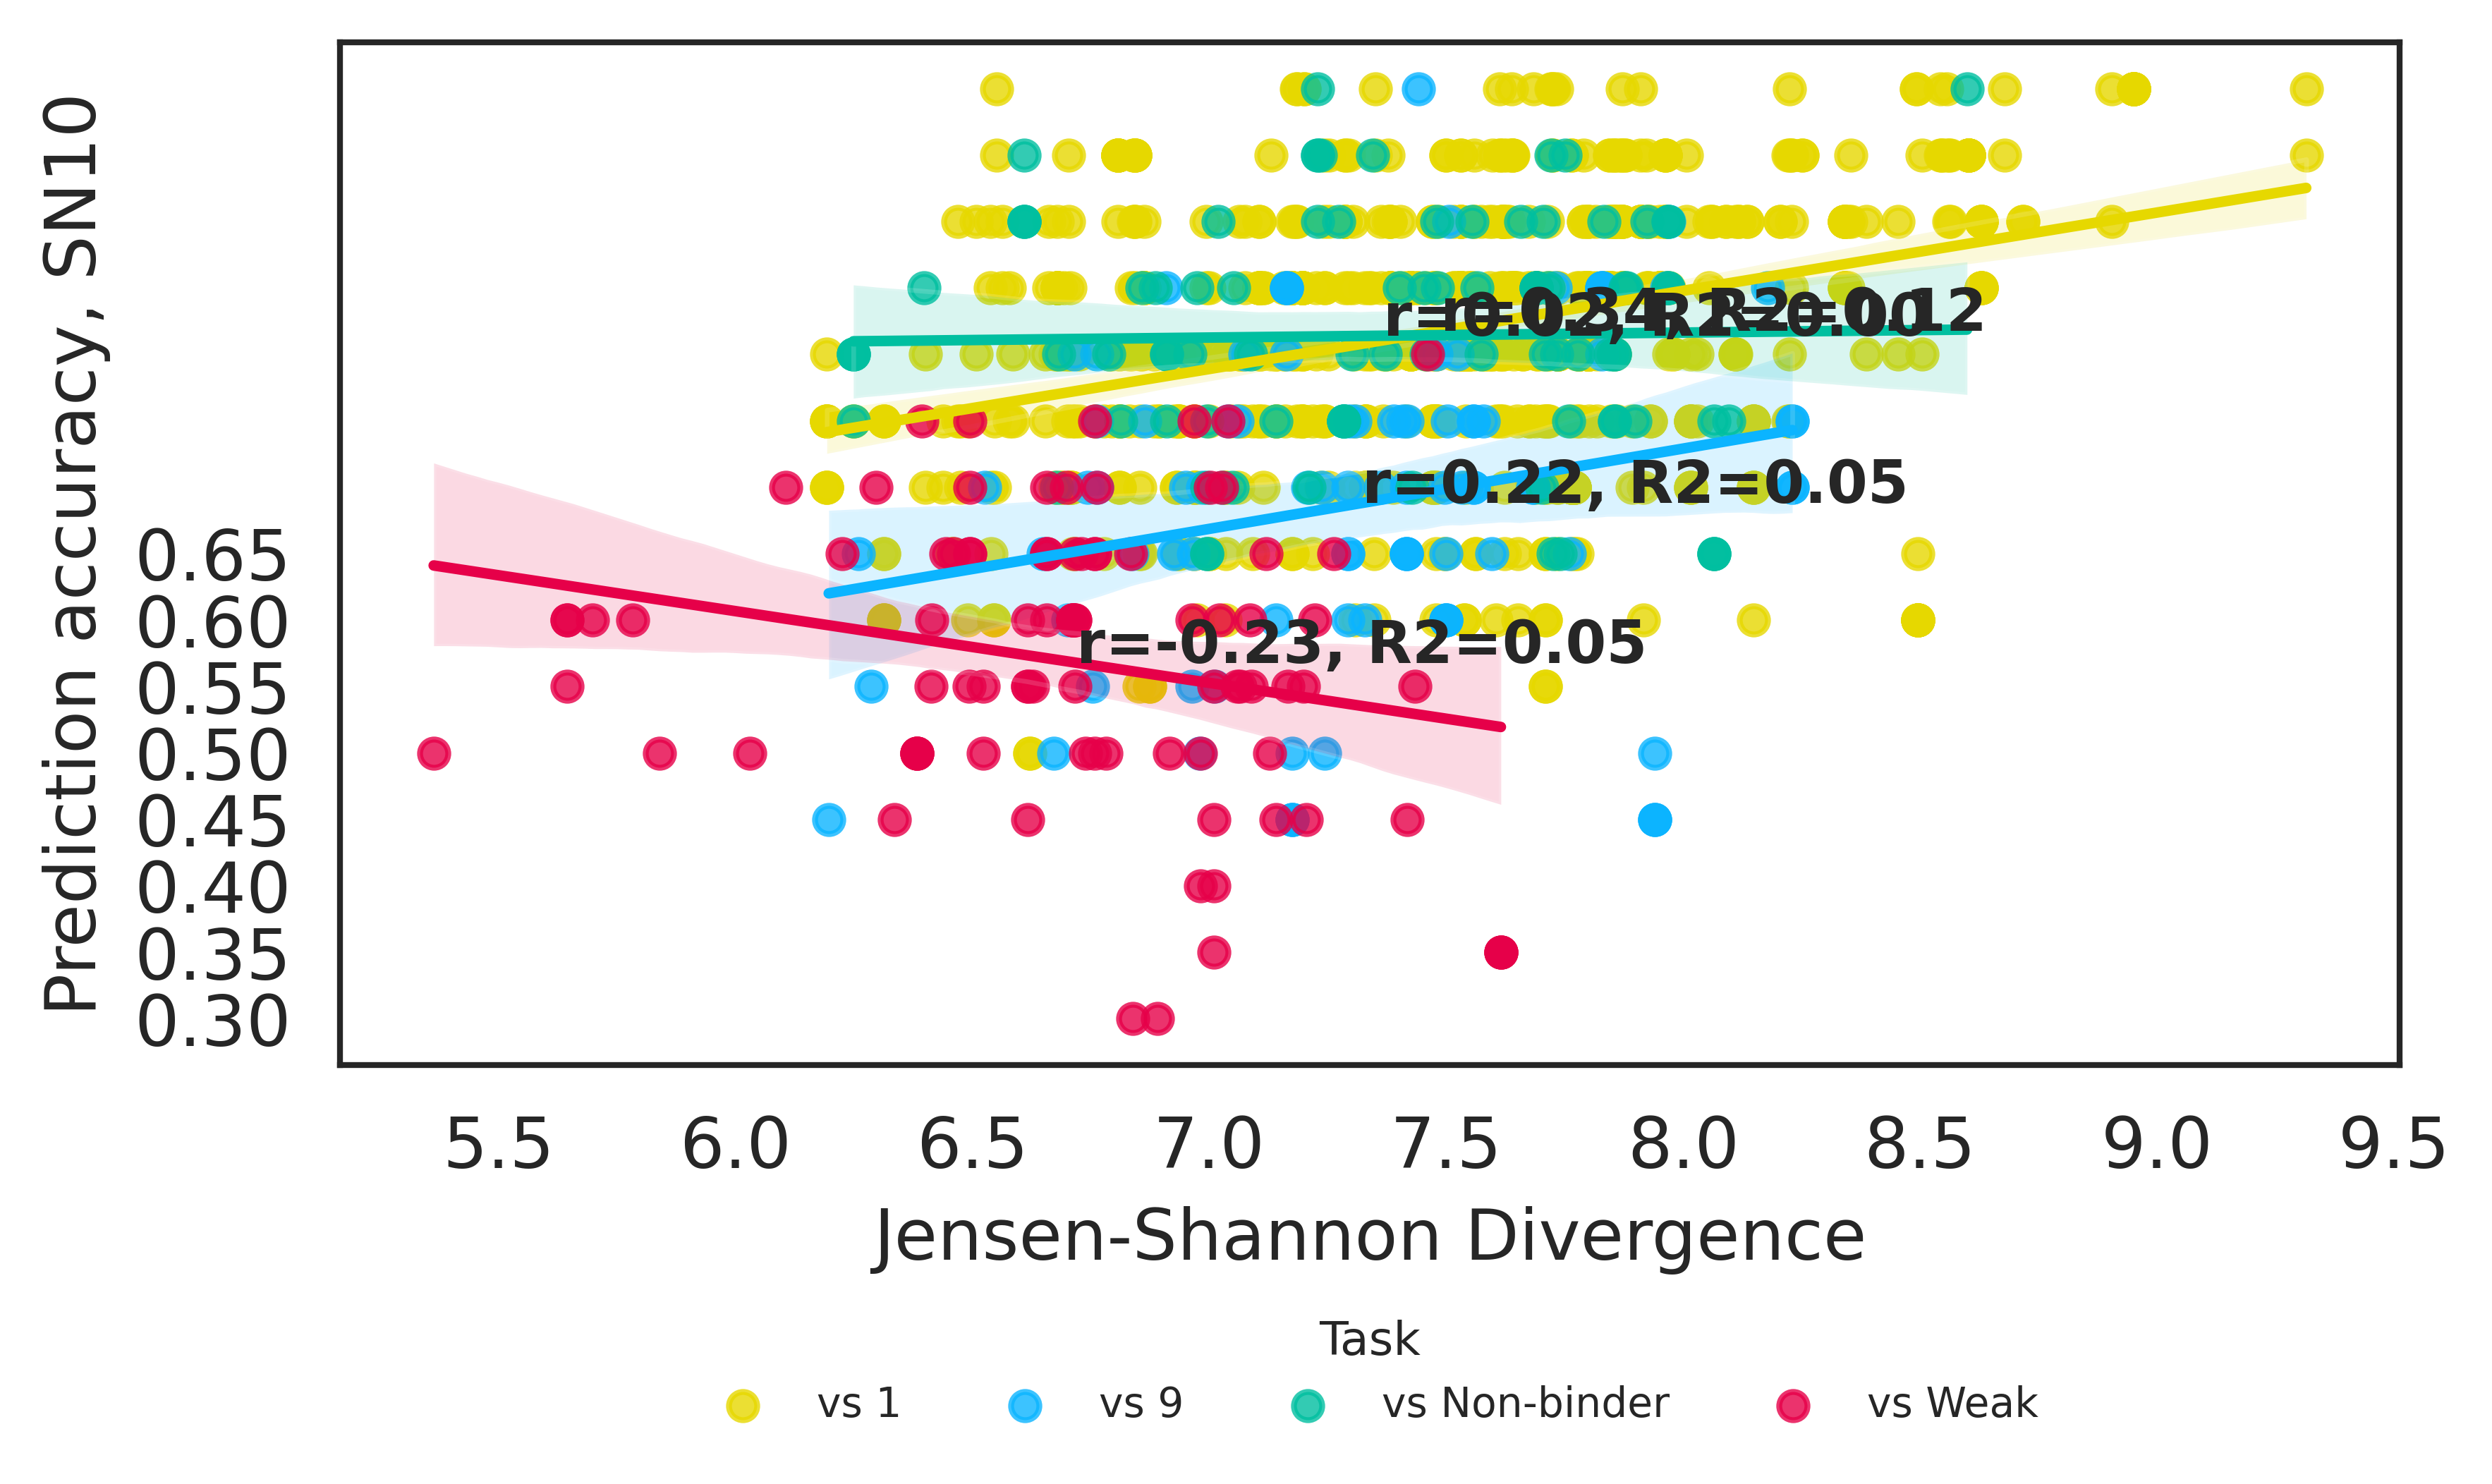

In [11]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for i, df_g in df.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="jsd",
        y="acc_closed",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

fig.savefig("figures/1B.svg")
fig.show()

In [12]:
for i, df_g in df.groupby("task_type_clean"):
    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")

vs 1: r=0.34, p=0.00
vs 9: r=0.22, p=0.04
vs Non-binder: r=0.02, p=0.84
vs Weak: r=-0.23, p=0.03


In [13]:
df.groupby("task_type_clean")["jsd"].agg(["mean", "std", "size"]).round(3).loc[task_clean_order]

mean    std  size
task_type_clean                    
vs Non-binder    7.367  0.507    89
vs 1             7.488  0.568   810
vs 9             7.323  0.453    89
vs Weak          6.719  0.462    89

In [14]:
df.groupby("task_type_clean").size()

task_type_clean
vs 1             810
vs 9              89
vs Non-binder     89
vs Weak           89
dtype: int64

## OOD
Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [15]:
df_o = pd.read_csv("../data/openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(77577, 10)


task_1                             task_2   acc  \
0  ONE_VS_ONE__3VRL__1FBI__2__42   HIGH_VS_95LOW__3VRL__auto__1__42  0.55   
1  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_LOOSER__3VRL__auto__1__42  0.40   
2  ONE_VS_ONE__3VRL__1FBI__2__42     ONE_VS_NINE__3VRL__auto__1__42  0.55   
3  ONE_VS_ONE__3VRL__1FBI__2__42   HIGH_VS_95LOW__3VRL__auto__2__42  0.55   
4  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_LOOSER__3VRL__auto__2__42  0.40   

   recall  precision        f1    ag task_1_type     task_2_type replicate_id  
0     0.6   0.545455  0.571429  3VRL         1v1   high_vs_95low         2_42  
1     0.6   0.428571  0.500000  3VRL         1v1  high_vs_looser         2_42  
2     0.6   0.545455  0.571429  3VRL         1v1             1v9         2_42  
3     0.6   0.545455  0.571429  3VRL         1v1   high_vs_95low         2_42  
4     0.6   0.428571  0.500000  3VRL         1v1  high_vs_looser         2_42

In [16]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

In [17]:
df_o["ag"].unique()

array(['3VRL', '1NSN', '1H0D', '1WEJ', '1ADQ', '1FBI', '2YPV', '1OB1'],
      dtype=object)

0 1FBI
1 3VRL
2 2YPV
3 5E94


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4 1WEJ
5 1OB1
6 1NSN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7 1H0D
8 3RAJ
9 1ADQ


/tmp/ipykernel_303215/3277572241.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


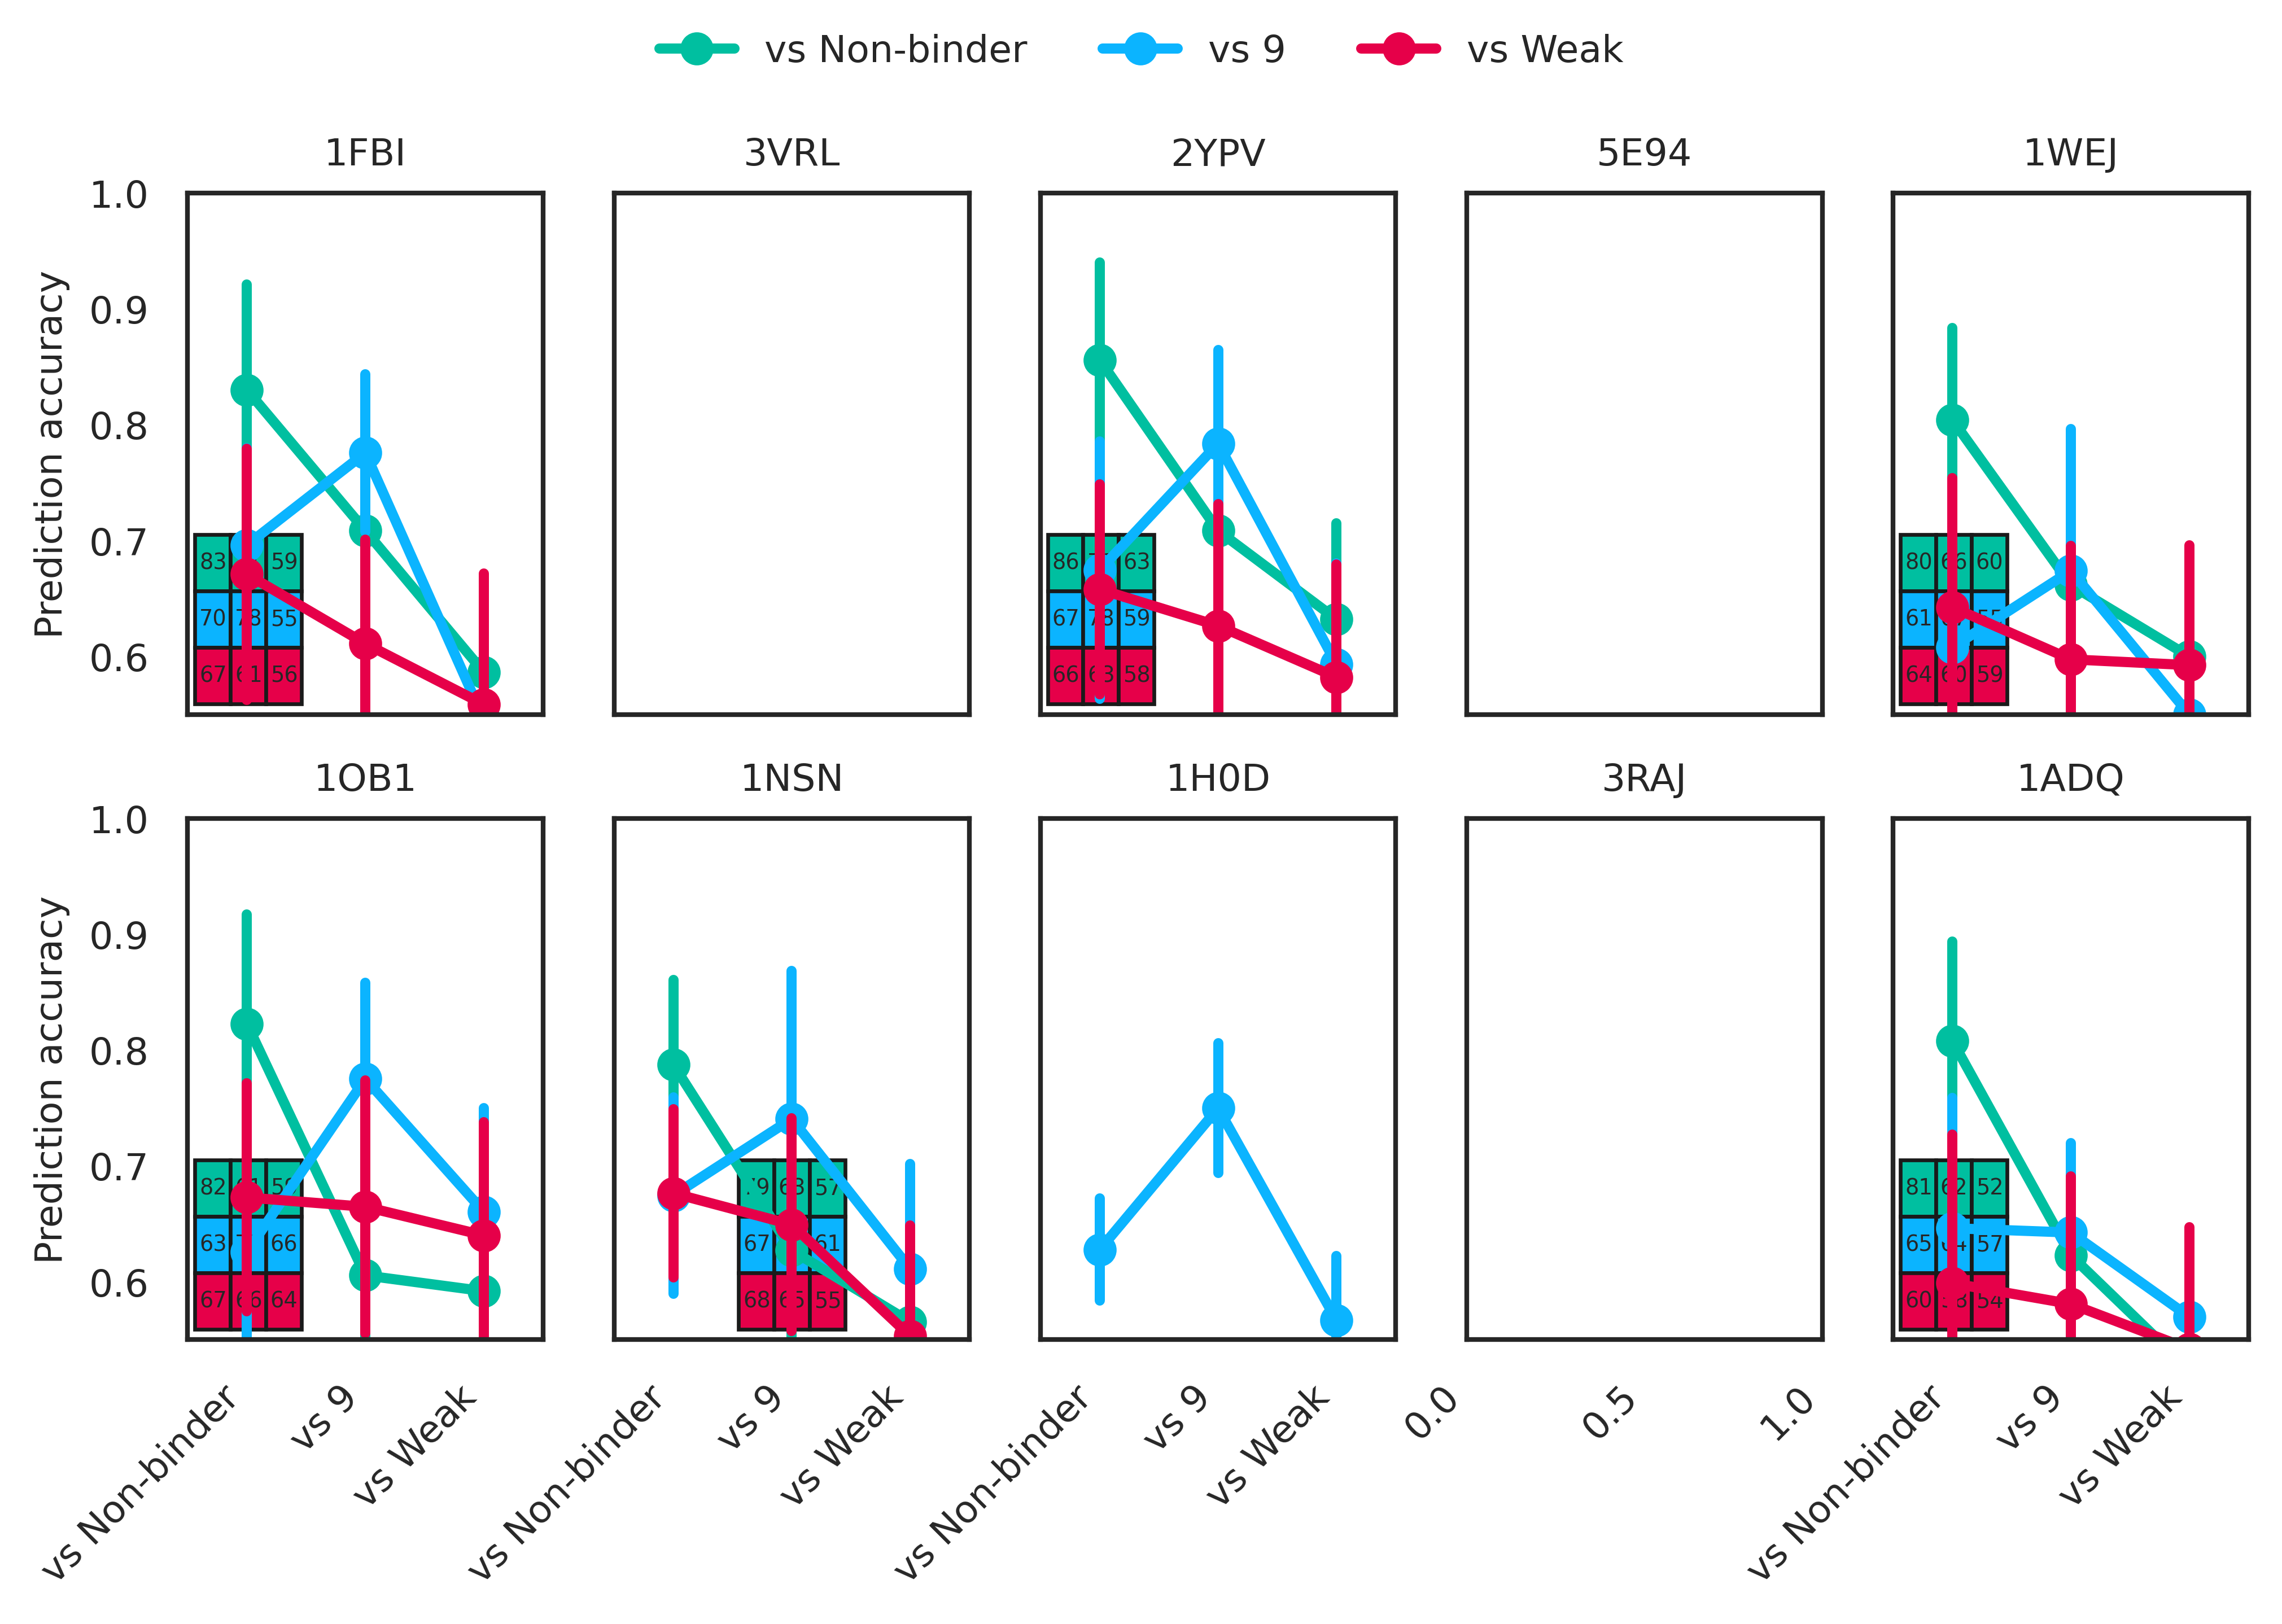

In [18]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

task_order = visualisations.PlotParams.order_tasks_clean.copy()
task_order.remove("vs 1")

for i, ag in enumerate(visualisations.PlotParams.order_antigens):
    print(i, ag)
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    df_i = df_o.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.55, 1.0)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

    # Tables inside the plot
    if row == 1 and col in [1, 2]:
        loc = "lower center"
    else:
        loc = "lower left"
    try:
        table_values = (
            df_i.groupby(["model_task", "test_task"])["acc"]
            .mean()
            .reset_index()
            .pivot(index="model_task", columns="test_task", values="acc")
            .loc[task_order][task_order]
            .values * 100).round().astype(int)
        table_values = np.where(table_values == 100, "", table_values)
        ax.table(
            cellText=table_values,
            loc=loc,
            colWidths=[0.1, 0.1, 0.1],
            cellColours=np.array([cmap for _ in range(3)]).transpose(),
        )
    except:
        pass

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

# Add text horizontal under all subplots, as part of figure
# fig.text(0.5, 0.001, "Tested on", ha="center", fontsize=8);

fig.savefig("figures/1D1.svg")
fig.show()

/tmp/ipykernel_303215/1652152173.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


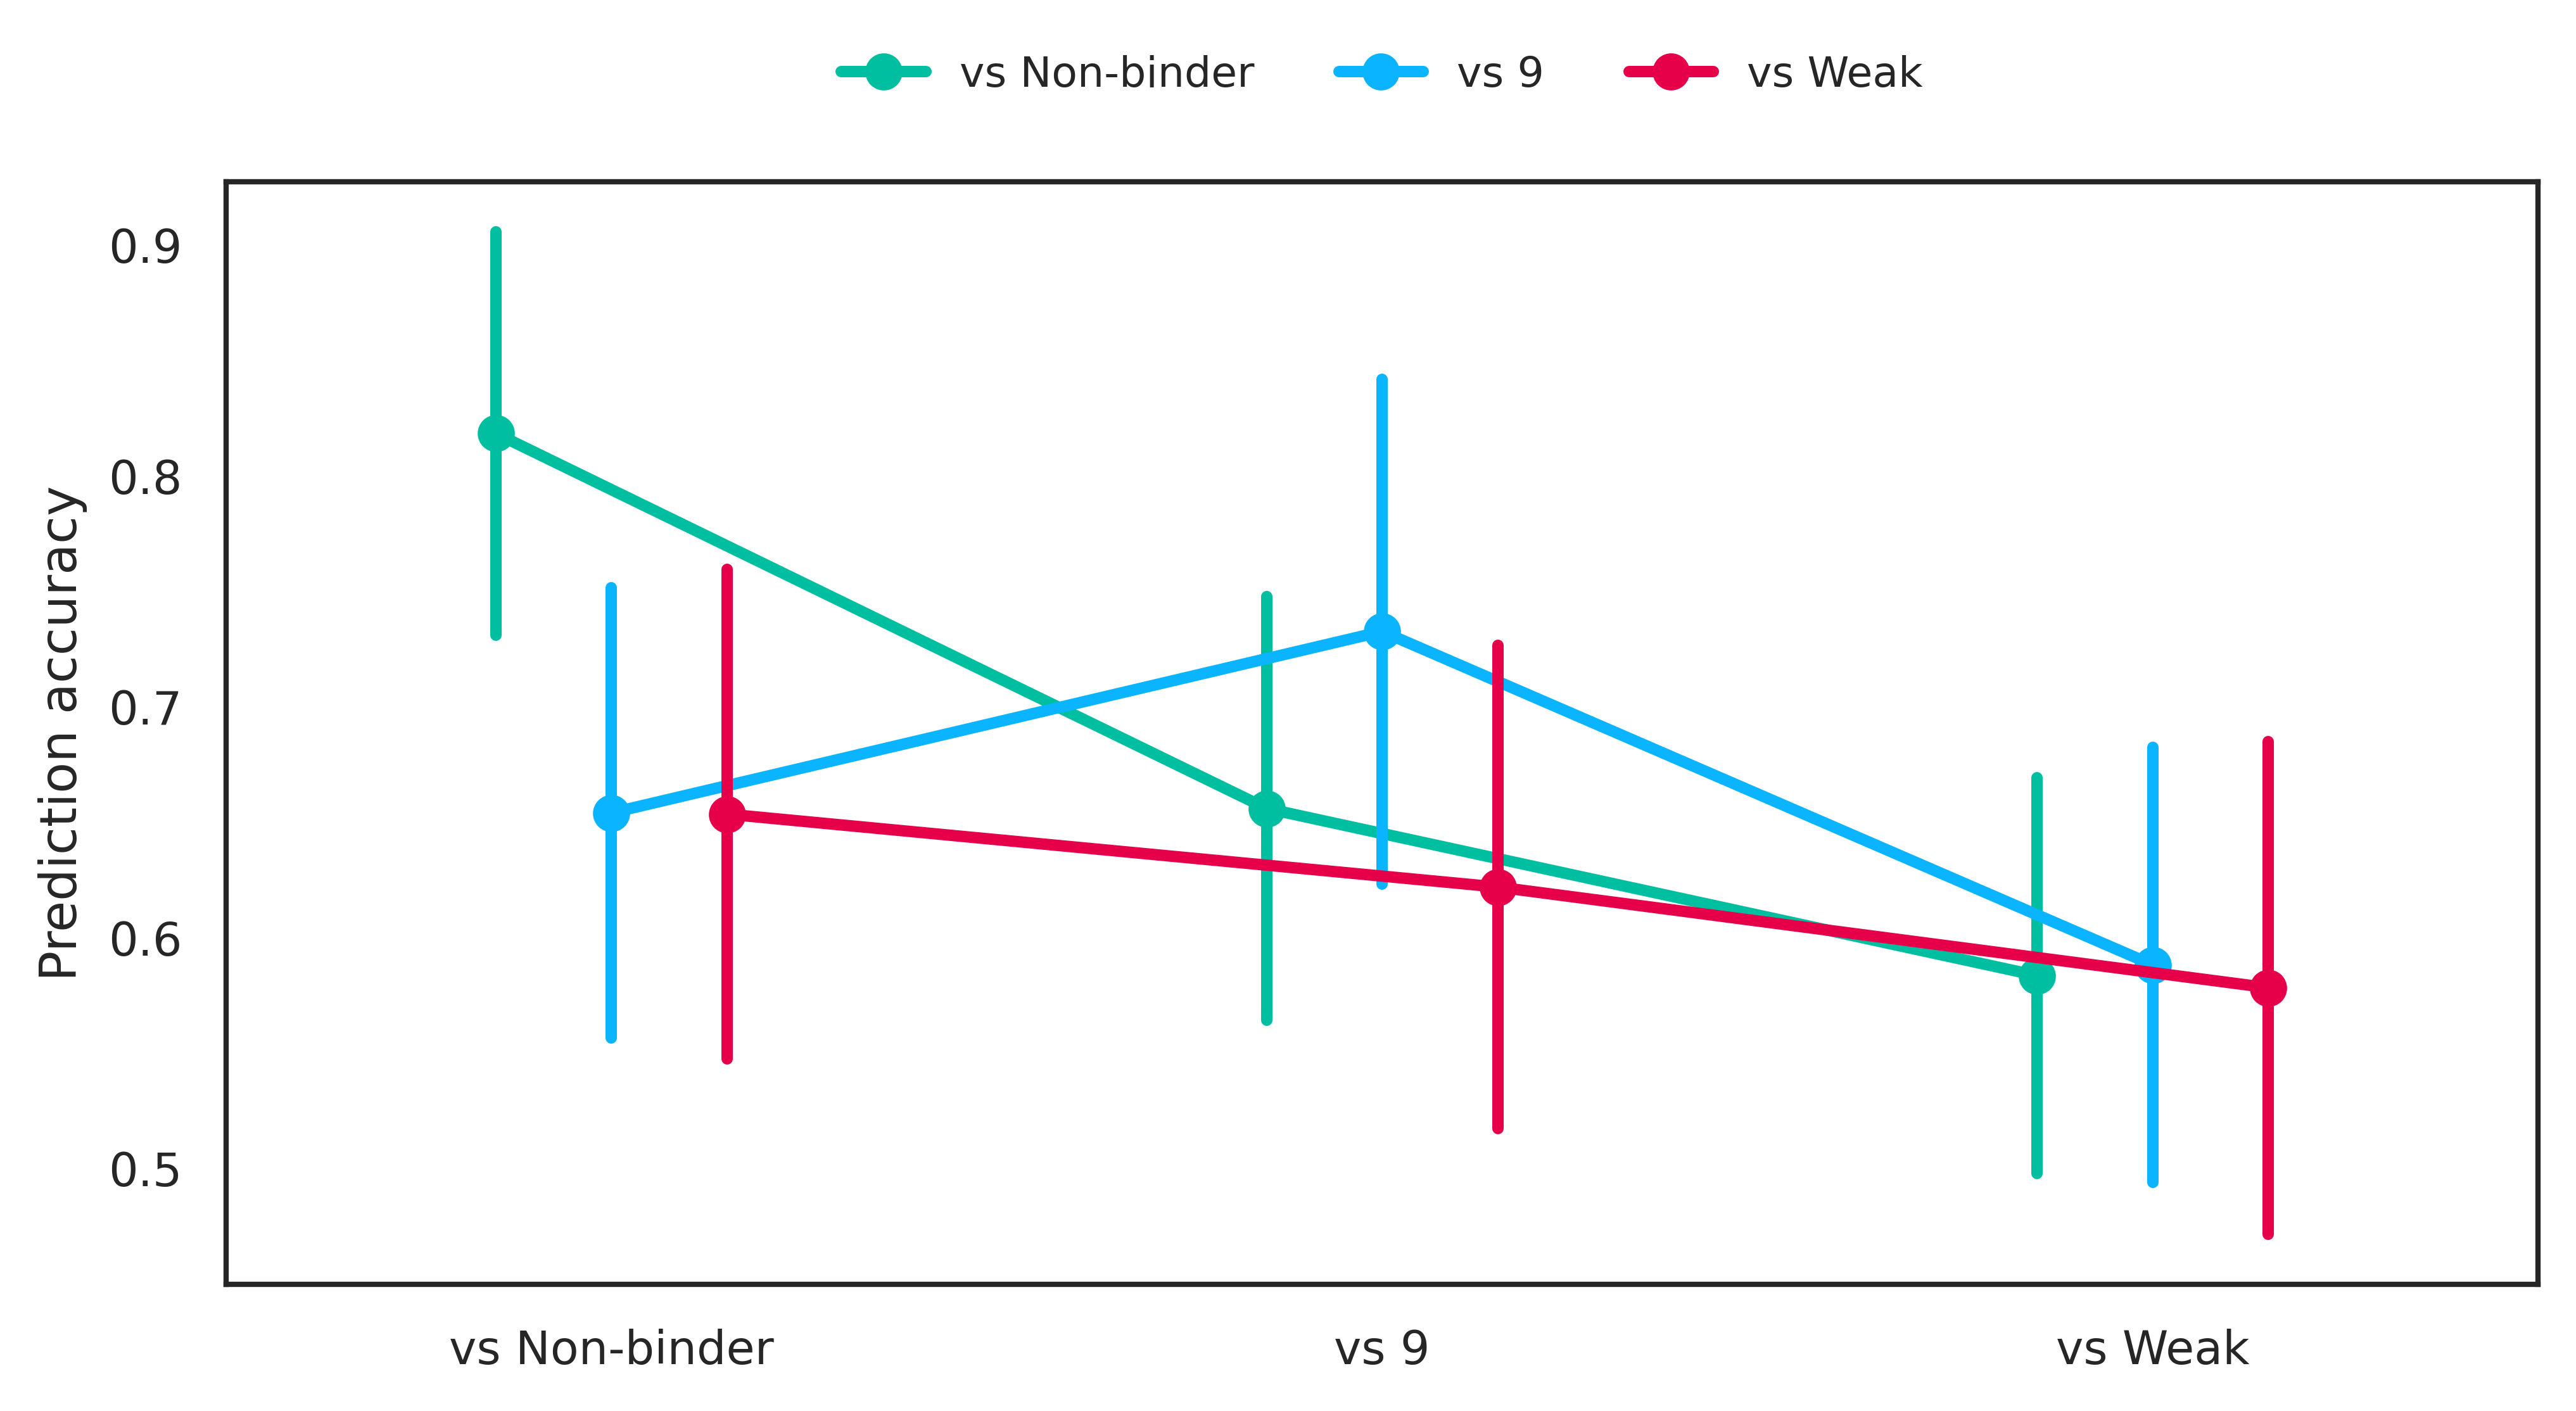

In [19]:
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.savefig("figures/1D2.svg")
fig.show()

In [20]:
# Table from the manuscript
df_g.columns

Index(['task', 'N_pos', 'N_neg', 'acc', 'recall', 'precision', 'f1', 'ag_pos',
       'ag_neg', 'seed_id', 'split_id', 'task_type', 'task_type_clean',
       'acc_closed', 'jsd'],
      dtype='object')

In [21]:
#.apply(["mean", "std"])
df.groupby("task_type")[["acc", "jsd"]] \
    .agg(["mean", "std"]) \
    .round(2)

acc         jsd      
                mean   std  mean   std
task_type                             
1v1             0.82  0.10  7.49  0.57
1v9             0.69  0.12  7.32  0.45
high_vs_95low   0.81  0.09  7.37  0.51
high_vs_looser  0.57  0.11  6.72  0.46

In [22]:
df_g["task_type"].unique()

array(['high_vs_looser'], dtype=object)

In [23]:
# TODO: ADD summaries from NC nb

## ID vs OOD

In [24]:
# Add in-distribution as separate column
df_o["is_indistribution"] = df_o["model_task"] == df_o["test_task"]
df_o_indistr = df_o.loc[df_o["is_indistribution"]].copy()
df_o = pd.merge(df_o, df_o_indistr[["task_1", "acc"]], on=["task_1"], suffixes=("", "_ID"))

df_o.head()

task_1                            task_2   acc  \
0  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_95LOW__3VRL__auto__1__42  0.55   
1  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_95LOW__3VRL__auto__1__42  0.55   
2  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_95LOW__3VRL__auto__1__42  0.55   
3  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_95LOW__3VRL__auto__1__42  0.55   
4  ONE_VS_ONE__3VRL__1FBI__2__42  HIGH_VS_95LOW__3VRL__auto__1__42  0.55   

   recall  precision        f1    ag task_1_type    task_2_type replicate_id  \
0     0.6   0.545455  0.571429  3VRL         1v1  high_vs_95low         2_42   
1     0.6   0.545455  0.571429  3VRL         1v1  high_vs_95low         2_42   
2     0.6   0.545455  0.571429  3VRL         1v1  high_vs_95low         2_42   
3     0.6   0.545455  0.571429  3VRL         1v1  high_vs_95low         2_42   
4     0.6   0.545455  0.571429  3VRL         1v1  high_vs_95low         2_42   

  model_task      test_task  is_indistribution  acc_ID  
0       vs 1  vs Non-binder              False    0.35  
1       vs 1  vs Non-binder              False    0.35  
2       vs 1  vs Non-binder              False    0.35  
3       vs 1  vs Non-binder              False    0.35  
4       vs 1  vs Non-binder              False    0.75

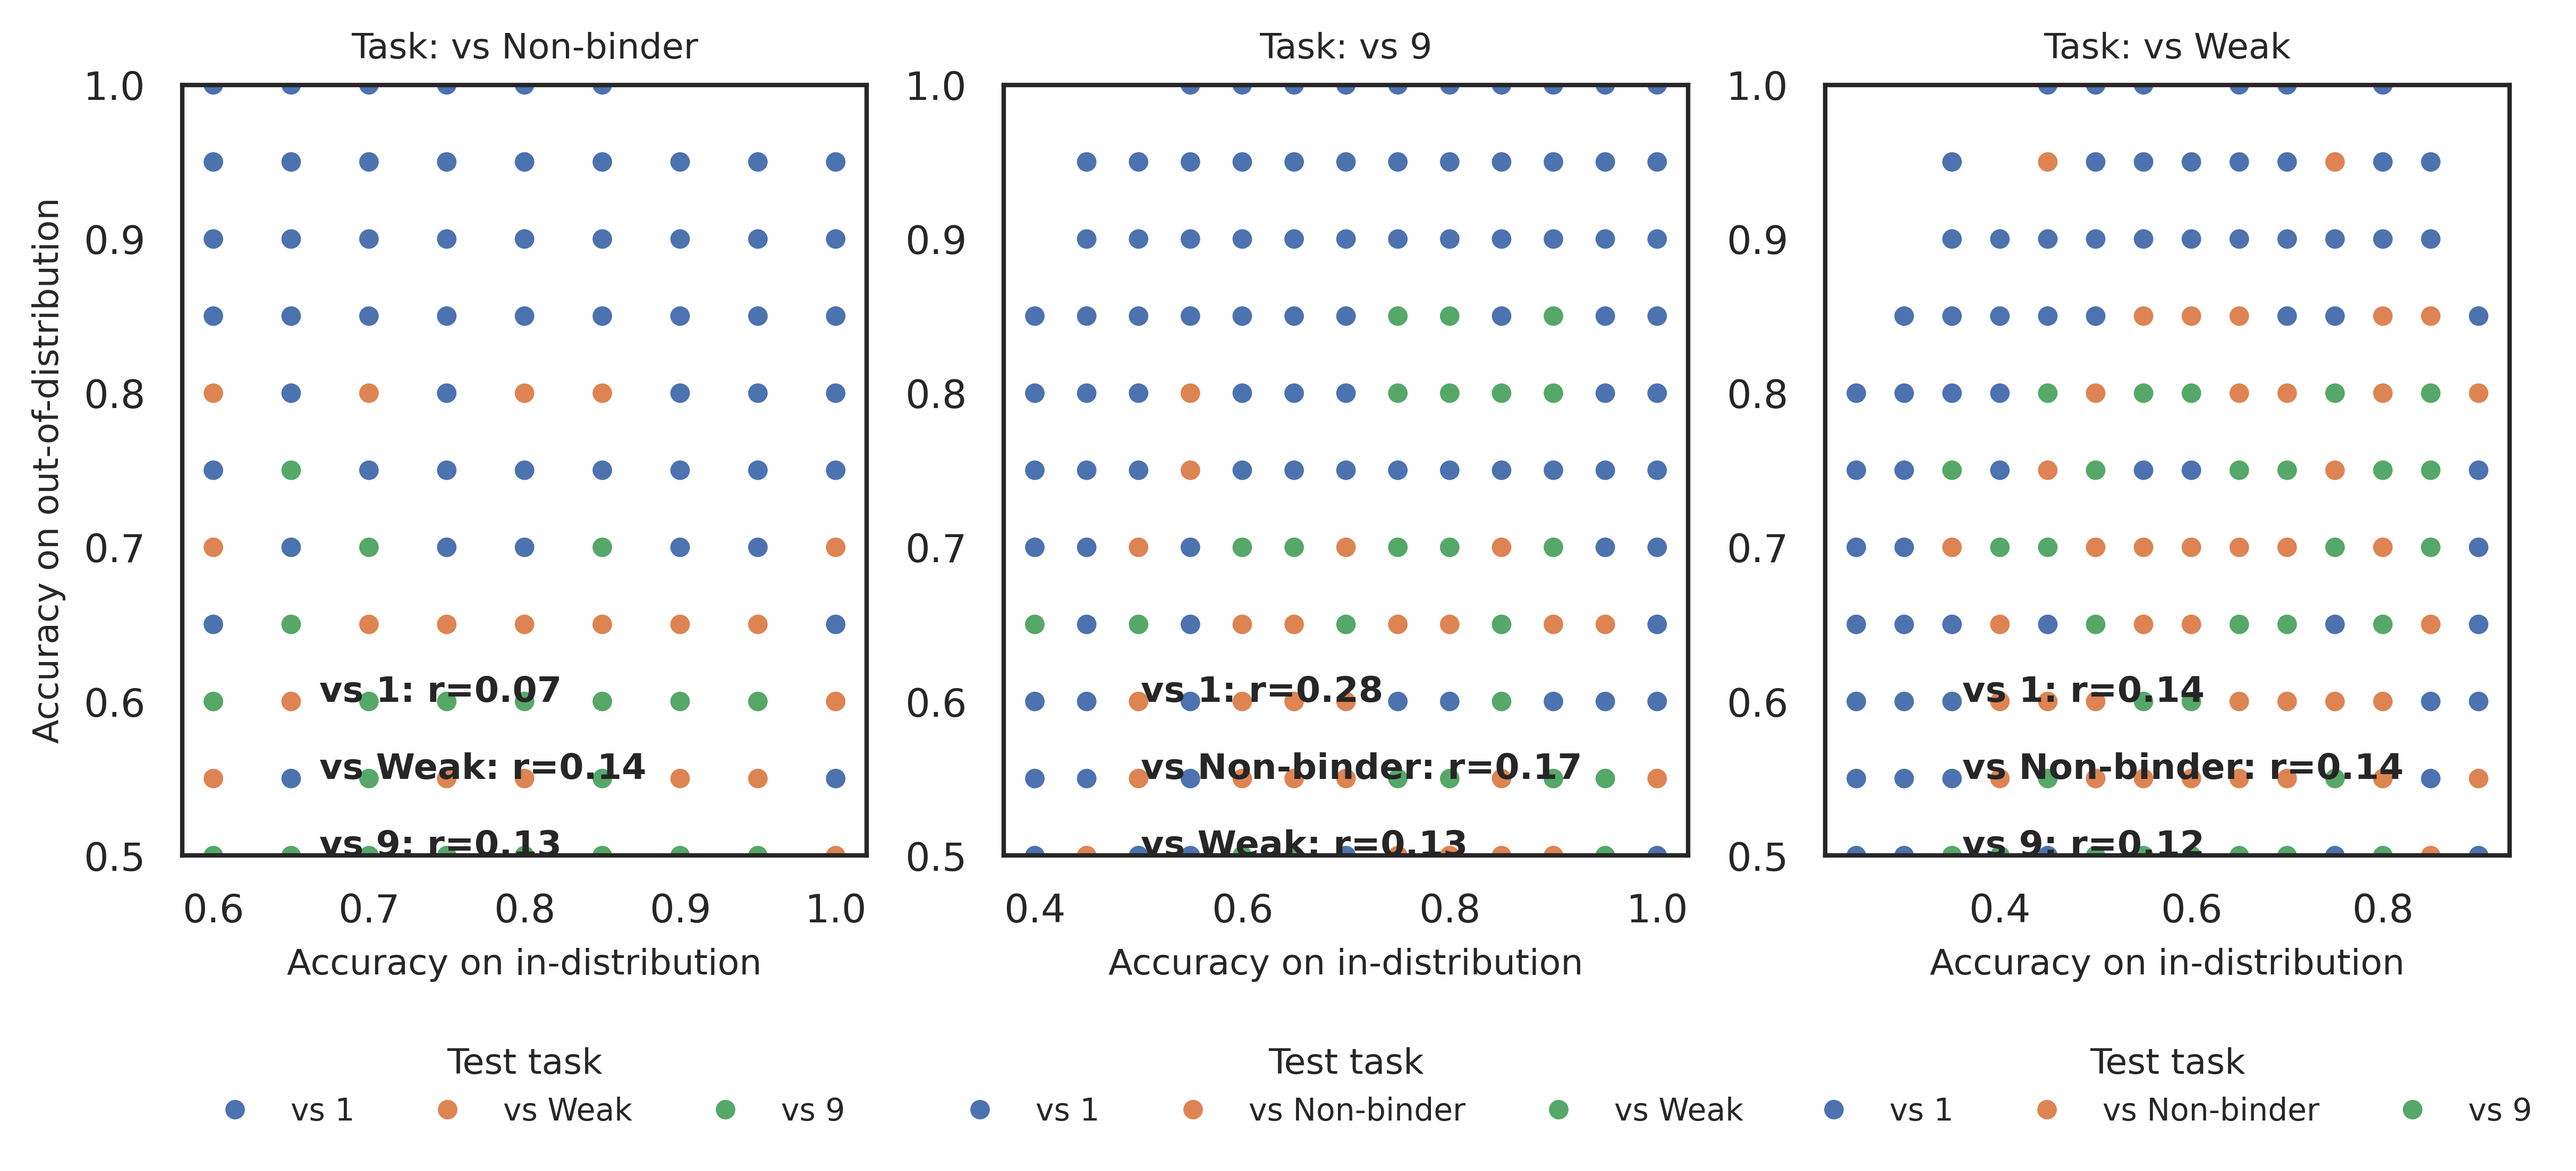

In [25]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * 3.14, 3.14), dpi=600)

task_order = visualisations.PlotParams.order_tasks_clean.copy()
task_order.remove("vs 1")

for i, task_i in enumerate(task_order):
    # row = 0
    col = i % 3
    ax = axs[col]
    df_i = df_o.query("model_task == @task_i").loc[~df_o["is_indistribution"]]
    sns.scatterplot(
        data=df_i,
        x="acc_ID",
        y="acc",
        hue="test_task",
        # pallette=cmap,
        ax=ax,
    )

    ax.set_title(f"Task: {task_i}", fontsize=8)
    ax.set_xlabel("Accuracy on in-distribution", fontsize=8)
    if col == 0:
        ax.set_ylabel("Accuracy on out-of-distribution", fontsize=8)
    else:
        ax.set_ylabel(None)
    # ax.set_xlim(0.8, 1.0)
    ax.set_ylim(0.5, 1.0)

    # Legend location under the plot
    ax.legend(
        bbox_to_anchor=(0.5, -0.3),
        loc="center",
        borderaxespad=0.0,
        fontsize=7,
        title="Test task",
        title_fontsize=8,
        ncol=10,
        frameon=False,
    )

    # Add correlation numbers in the plots
    # 2 numbers per plot, per test_task, 
    # with color corresponding to the plot hue
    for j, test_task in enumerate(df_i["test_task"].unique()):
        df_i_tt = df_i.query("test_task == @test_task")
        r, pval = pearsonr(df_i_tt["acc_ID"], df_i_tt["acc"])
        ax.text(
            0.2,
            0.2 - 0.1 * j,
            f"{test_task}: r={r:.2f}",
            fontsize=8,
            fontweight="bold",
            transform=ax.transAxes,
        )
    


In [26]:
df_o.to_csv("../data/Frozen_MiniAbsolut_ML/openset_performance_ext.tsv", sep="\t", index=False)